The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
training_subfolder = "wind_near_wall_bemt_fitting"
# training_subfolder = "wind_near_wall_bemt_fitting_validation"
# training_subfolder = "wind_near_wall_bemt_fitting_zero"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_bemt_fitting_validation"
# validation_subfolder = "wind_near_wall_bemt_fitting_validation_sinusoidal"
# validation_subfolder = "wind_near_wall_bemt_fitting_zero_validation"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn1_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn1_0_y0_0_z3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn1_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn1_0_y0_0_zn3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn1_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z3_0_d100

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_bemt_fitting\normalization_params.yaml
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z3_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn3_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x

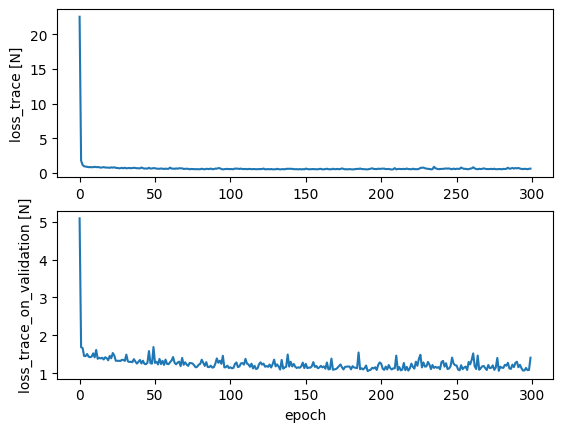

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(is_diaml=False)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
manager.train()

plt.show()  

Inspect data in the data list.

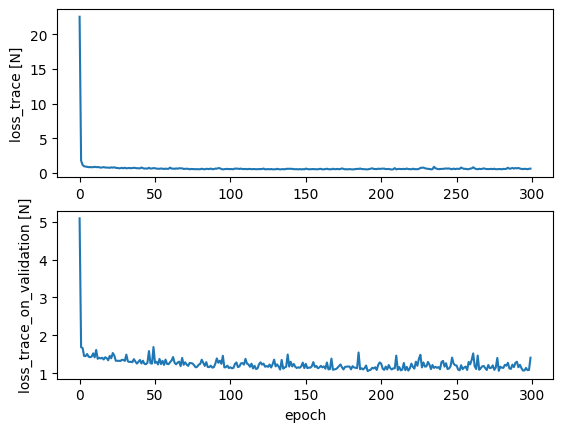

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_bemt_fitting.pth


Test the model using the test set.

test Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_vali

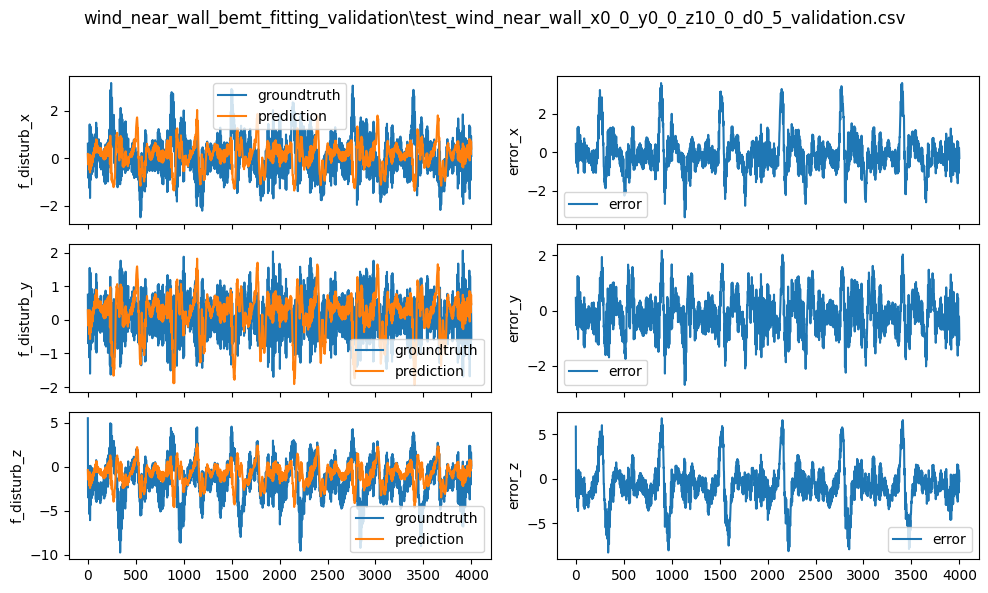

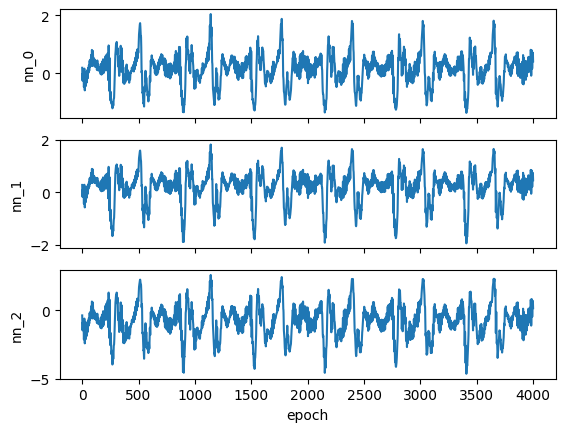

prediction: tensor([[ 0.3408,  0.3907,  0.0722],
        [ 0.1097,  0.1649, -0.4130],
        [-0.1023, -0.0838, -0.9055],
        ...,
        [ 0.2921,  0.3035,  0.5264],
        [ 0.1044,  0.1072,  0.1609],
        [-0.2442, -0.2763, -0.5796]])


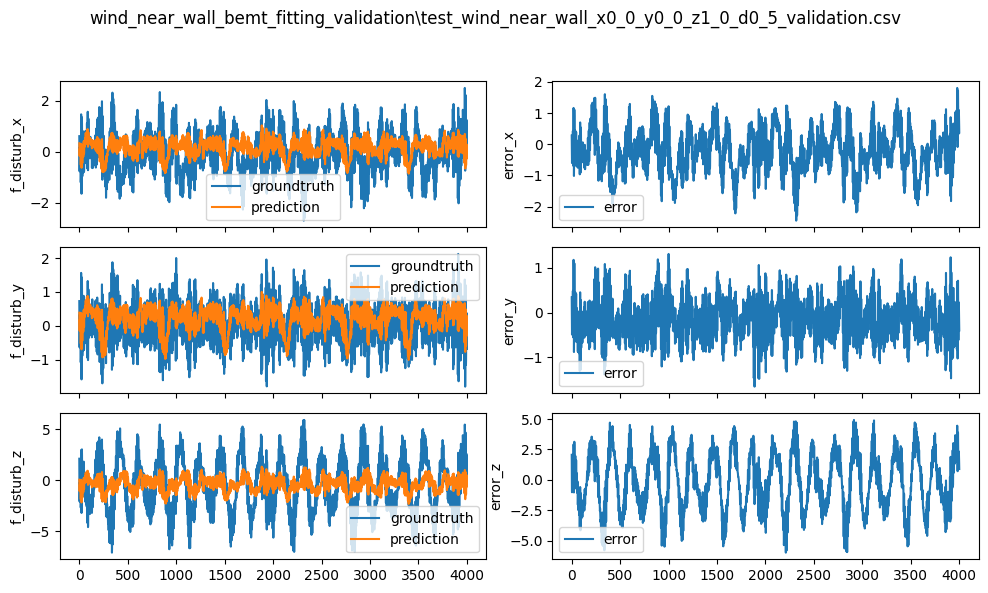

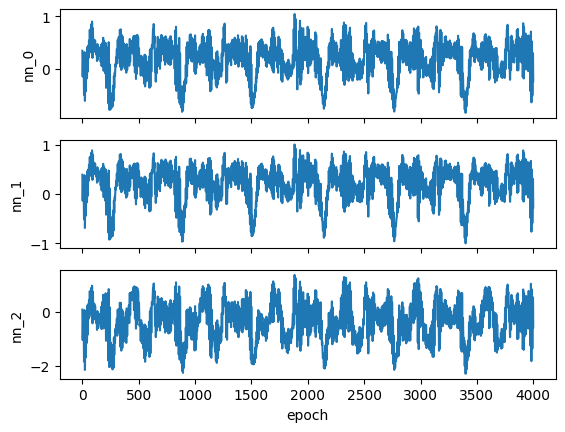

prediction: tensor([[ 0.2931,  0.3550, -0.0760],
        [ 0.0578,  0.1194, -0.5618],
        [-0.1178, -0.0775, -1.0003],
        ...,
        [ 0.1136,  0.1298,  0.0943],
        [-0.0965, -0.1180, -0.3262],
        [-0.3940, -0.4153, -1.0405]])


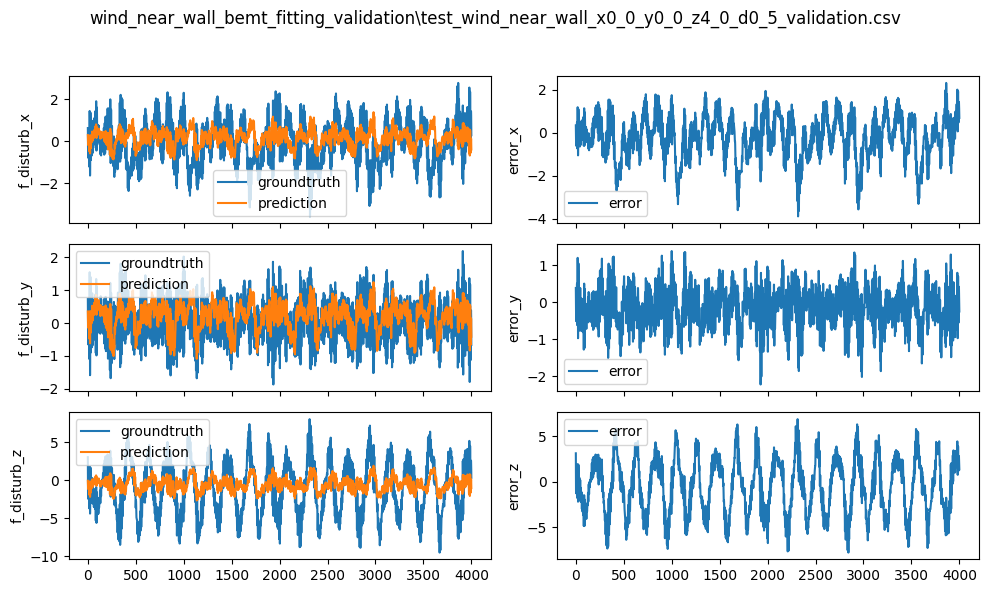

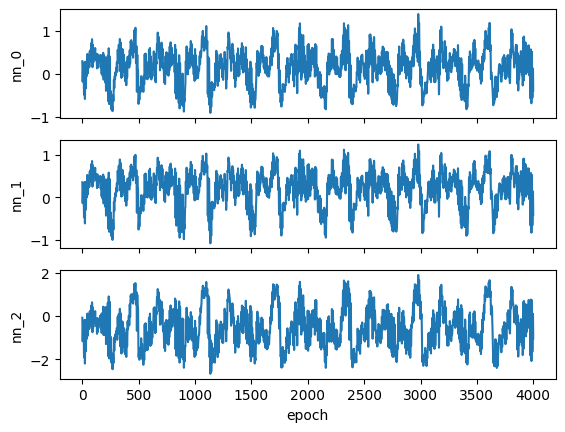

prediction: tensor([[ 0.5247,  0.5195,  0.5584],
        [ 0.2866,  0.2966,  0.0745],
        [ 0.0899,  0.0840, -0.3606],
        ...,
        [ 0.4485,  0.4146,  0.6041],
        [ 0.2676,  0.2434,  0.2746],
        [-0.0064, -0.0522, -0.2812]])


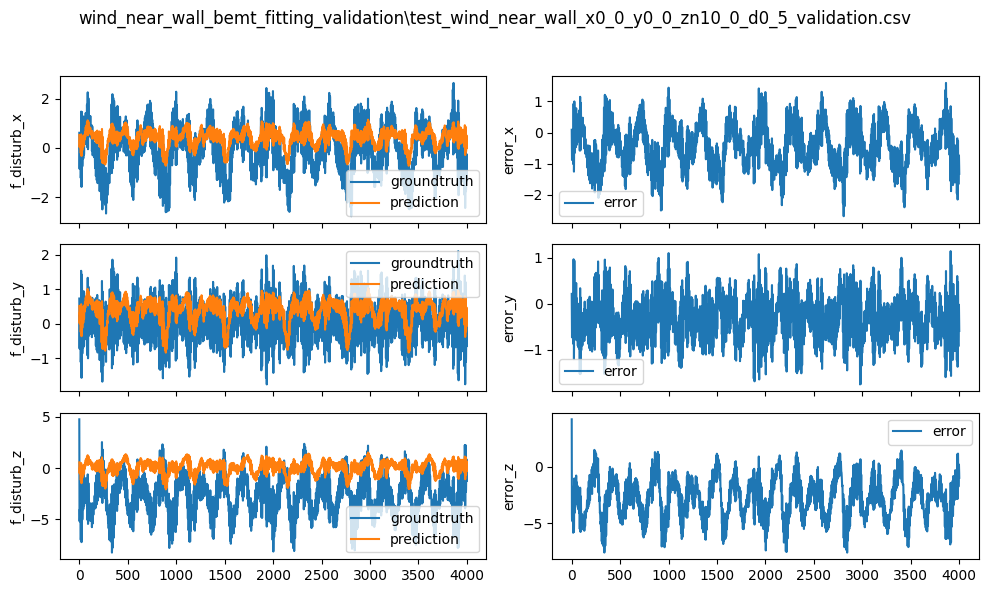

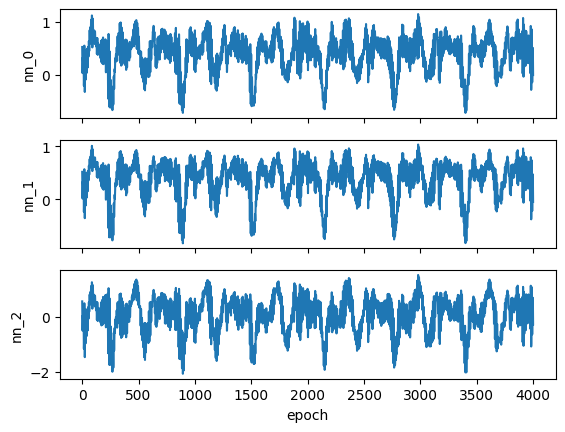

prediction: tensor([[ 0.3670,  0.4100,  0.1618],
        [ 0.1365,  0.1866, -0.3295],
        [-0.0639, -0.0590, -0.7662],
        ...,
        [ 0.2866,  0.2912,  0.4889],
        [ 0.1115,  0.1083,  0.1393],
        [-0.2164, -0.2575, -0.5456]])


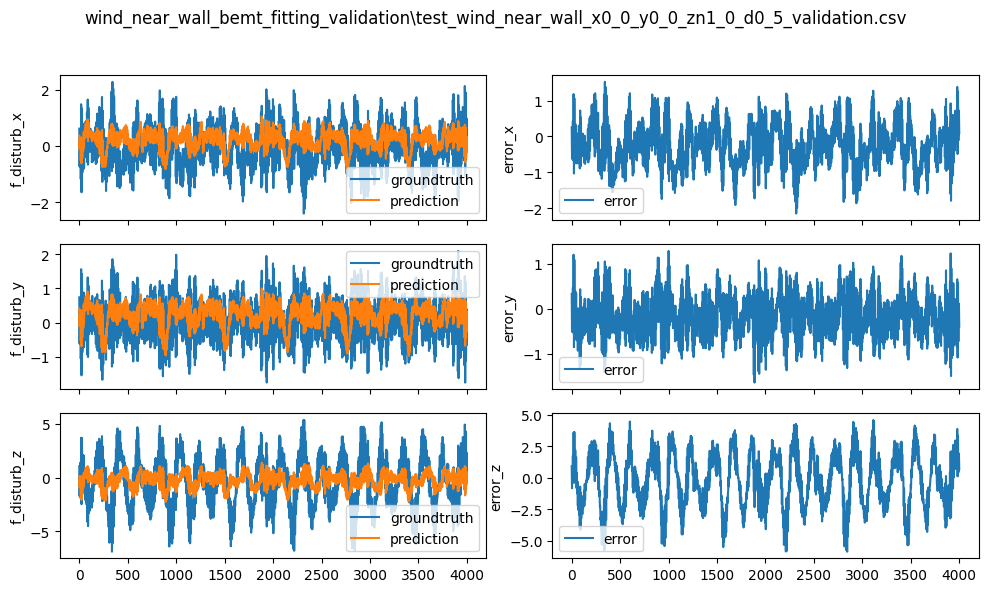

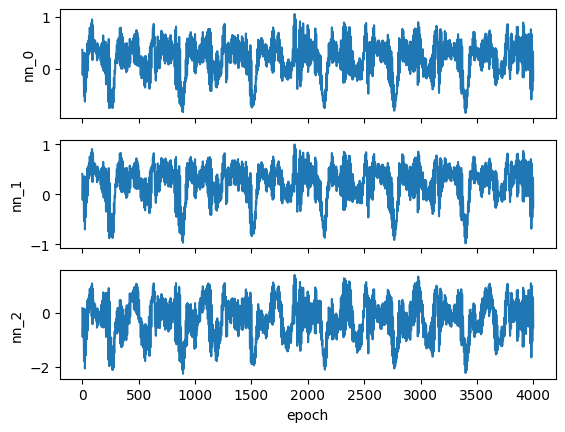

prediction: tensor([[ 0.4195,  0.4520,  0.3241],
        [ 0.2113,  0.2513, -0.1407],
        [-0.0224, -0.0221, -0.6248],
        ...,
        [ 0.3469,  0.3353,  0.5567],
        [ 0.1363,  0.1239,  0.1547],
        [-0.1644, -0.2106, -0.4474]])


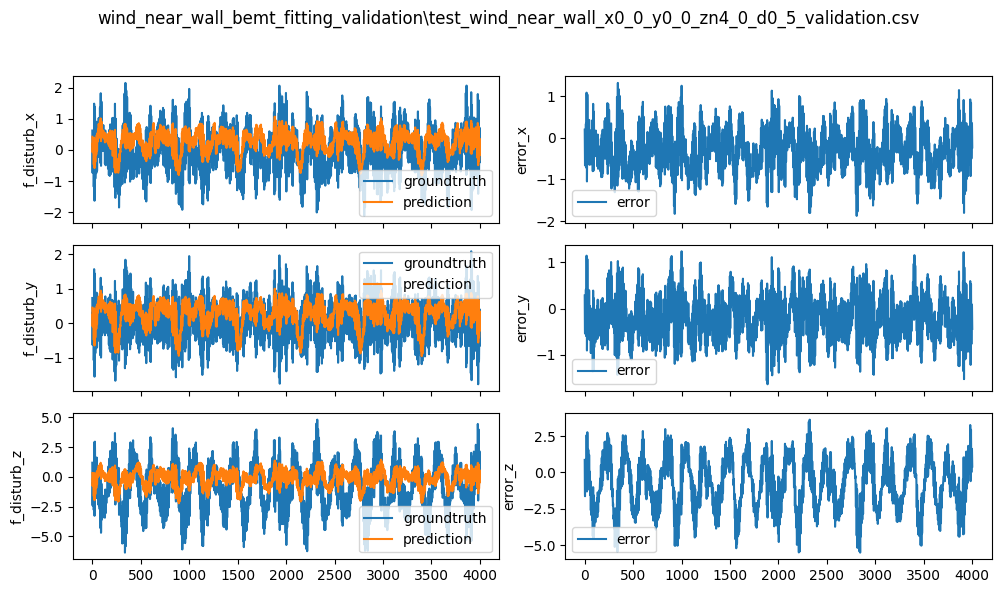

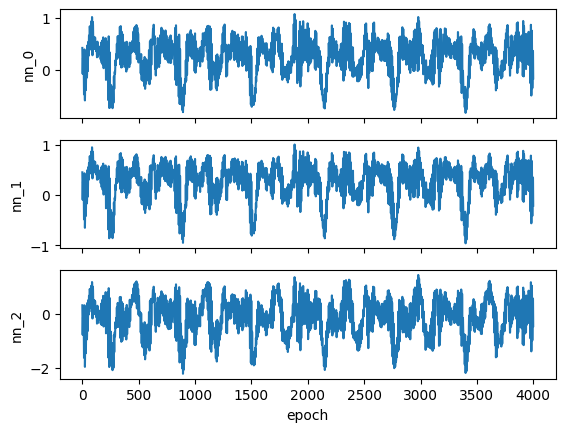

prediction: tensor([[ 0.2304,  0.3121, -0.3055],
        [-0.0061,  0.0794, -0.8049],
        [-0.2121, -0.1320, -1.3374],
        ...,
        [ 0.5510,  0.6029,  0.3835],
        [ 0.4276,  0.4799,  0.1204],
        [ 0.2563,  0.3091, -0.2663]])


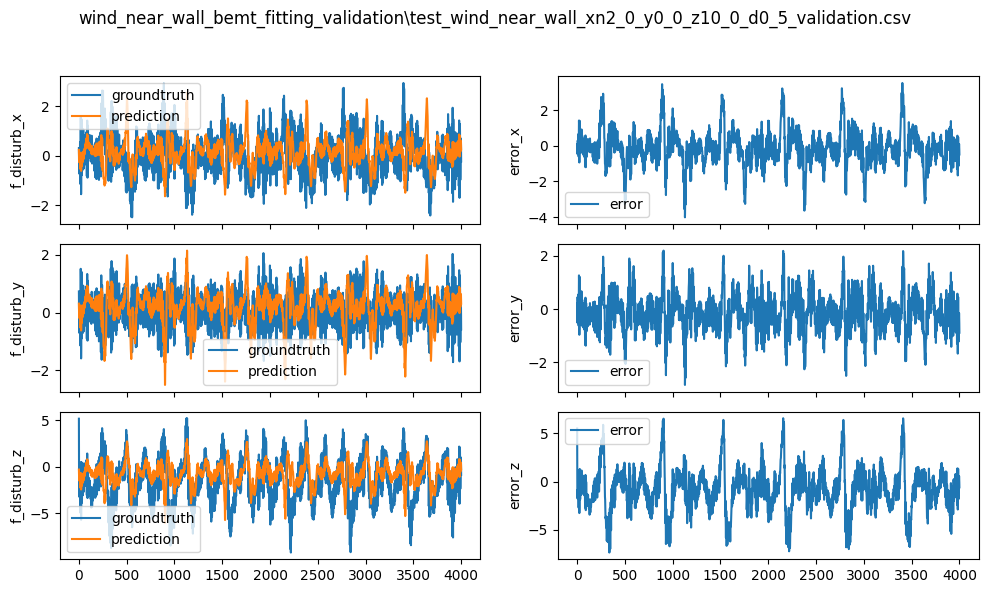

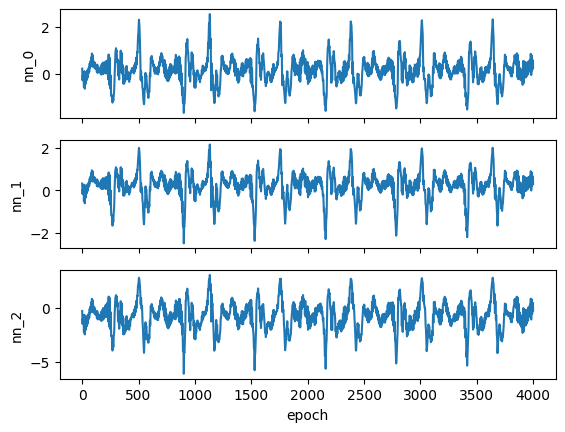

prediction: tensor([[ 0.3967,  0.4399,  0.1932],
        [ 0.1480,  0.1999, -0.3484],
        [-0.0751, -0.0636, -0.8469],
        ...,
        [ 0.2329,  0.2391,  0.4045],
        [ 0.0251,  0.0119, -0.0209],
        [-0.3123, -0.3390, -0.7691]])


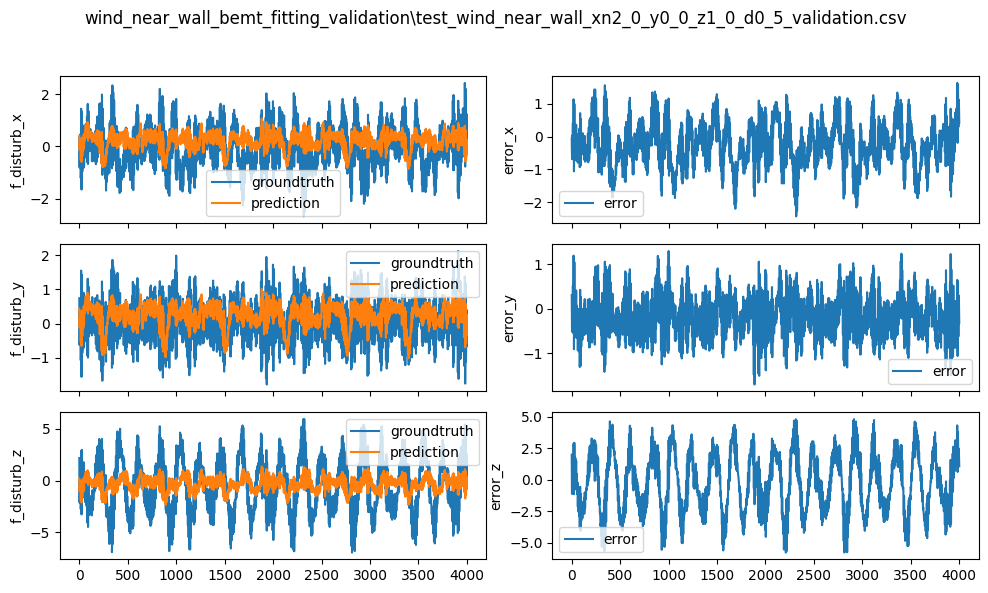

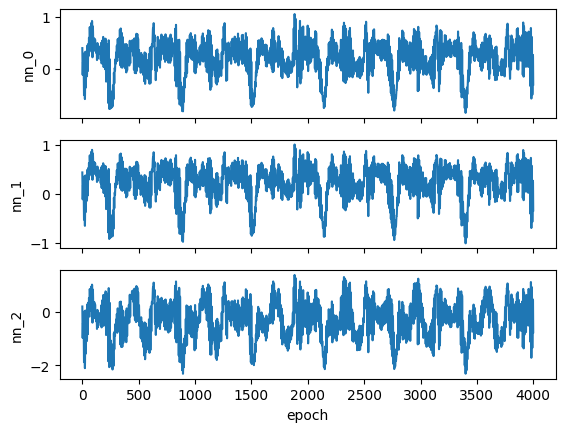

prediction: tensor([[ 0.3414,  0.3943,  0.0213],
        [ 0.0970,  0.1545, -0.5010],
        [-0.1058, -0.0735, -0.9913],
        ...,
        [-0.1634, -0.1743, -0.4214],
        [-0.3373, -0.3454, -0.8516],
        [-0.5546, -0.6163, -1.5069]])


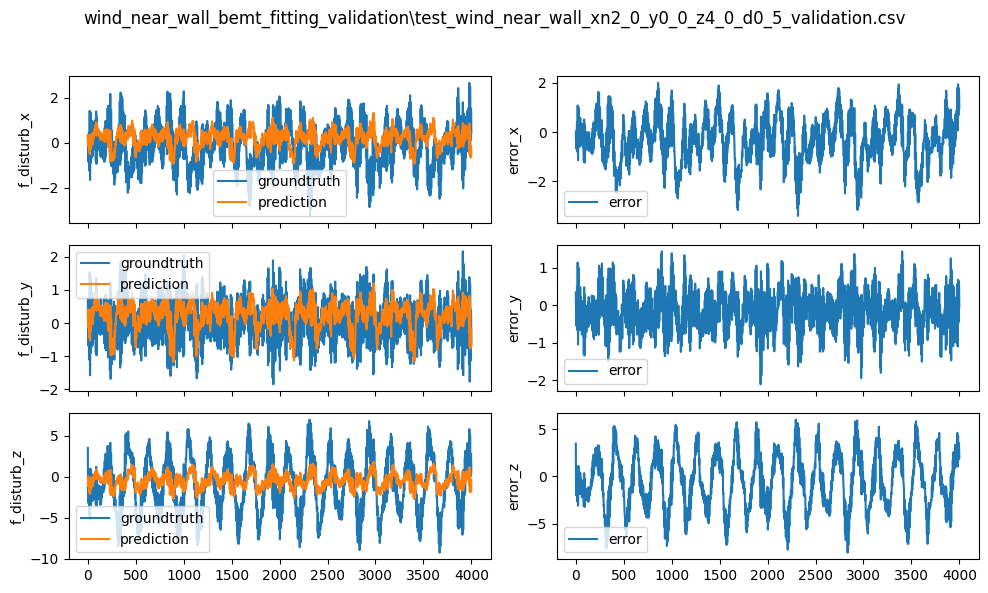

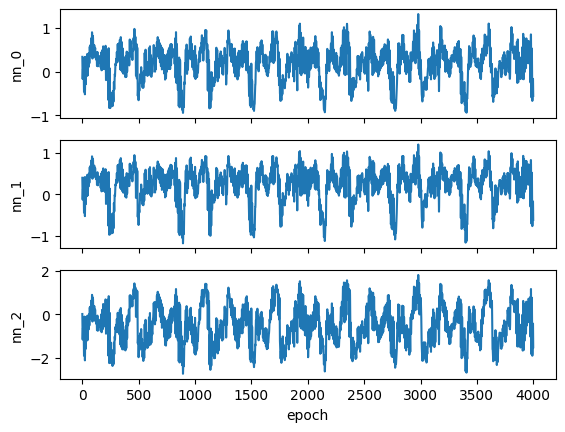

prediction: tensor([[ 0.5899,  0.5627,  0.6451],
        [ 0.3170,  0.3152,  0.1257],
        [ 0.0860,  0.0715, -0.3732],
        ...,
        [ 0.4815,  0.4331,  0.6538],
        [ 0.2922,  0.2551,  0.3238],
        [ 0.0160, -0.0385, -0.2350]])


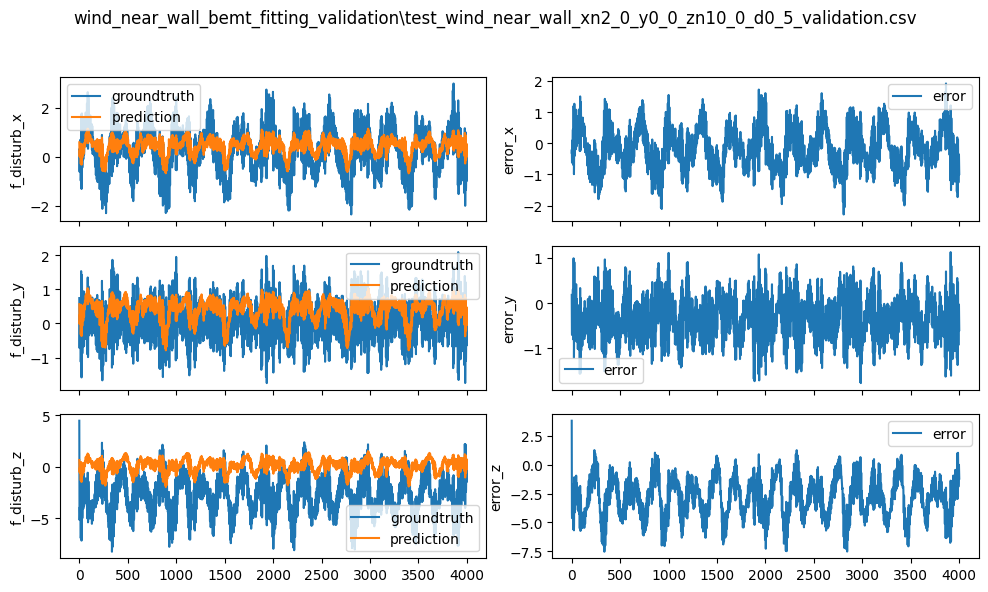

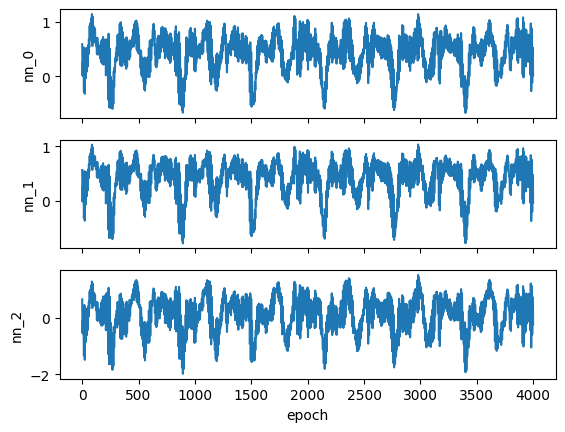

prediction: tensor([[ 0.4119,  0.4476,  0.2557],
        [ 0.1886,  0.2334, -0.2364],
        [-0.0481, -0.0502, -0.7357],
        ...,
        [ 0.3417,  0.3322,  0.5769],
        [ 0.1505,  0.1432,  0.2198],
        [-0.2238, -0.2742, -0.5596]])


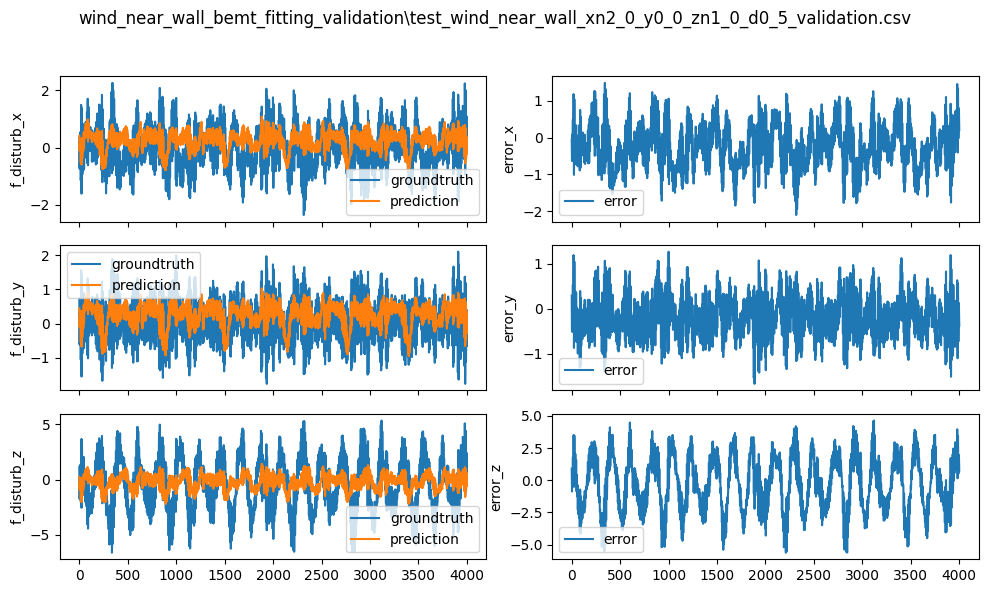

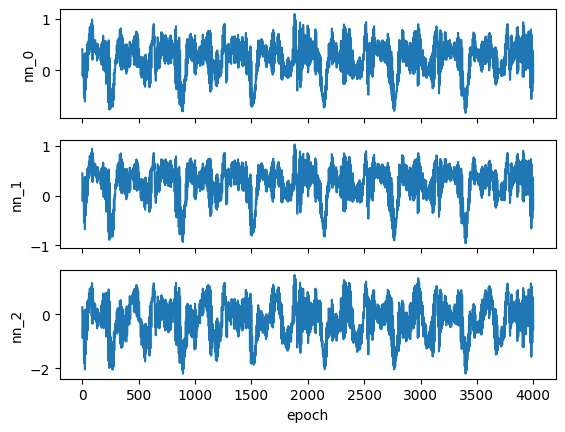

prediction: tensor([[ 0.4579,  0.4791,  0.3825],
        [ 0.2189,  0.2493, -0.1374],
        [-0.0066, -0.0067, -0.5942],
        ...,
        [ 0.3770,  0.3525,  0.6035],
        [ 0.1694,  0.1487,  0.2244],
        [-0.1473, -0.2013, -0.4069]])


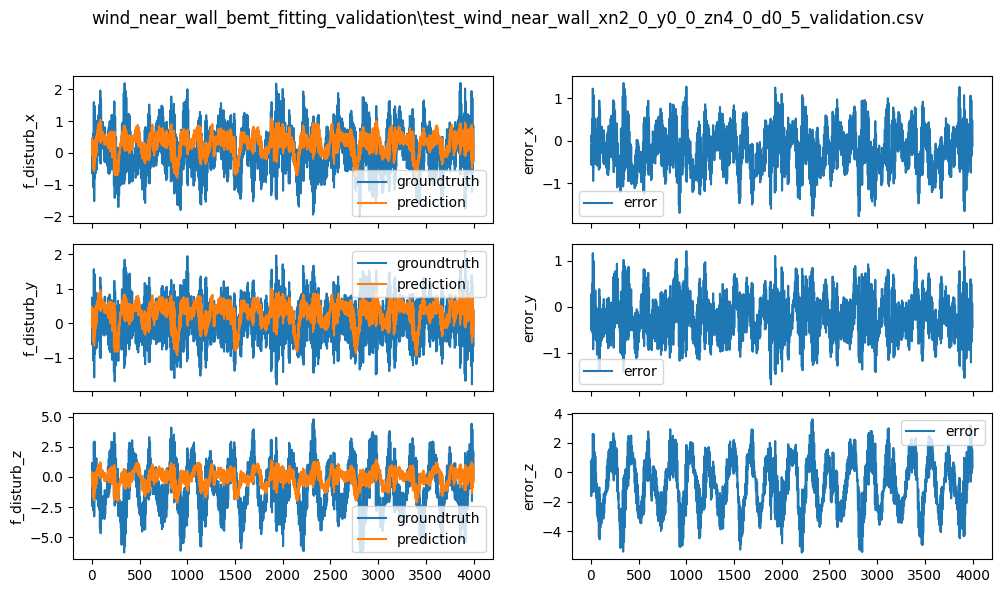

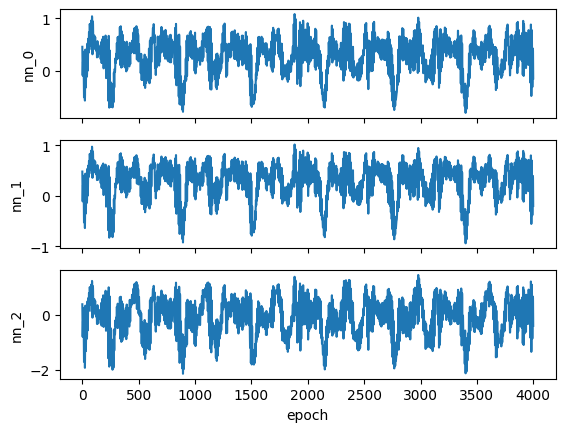

prediction: tensor([[ 0.3111,  0.3729, -0.1543],
        [ 0.0346,  0.1077, -0.7254],
        [-0.1892, -0.1183, -1.2900],
        ...,
        [ 0.5295,  0.5664,  0.4087],
        [ 0.3594,  0.3929,  0.0413],
        [ 0.1219,  0.1379, -0.4652]])


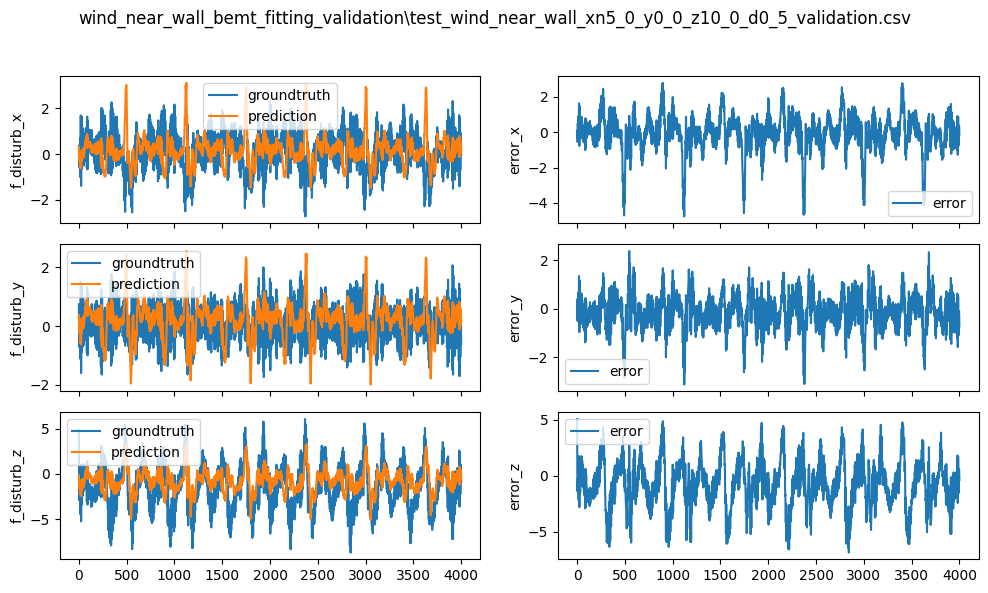

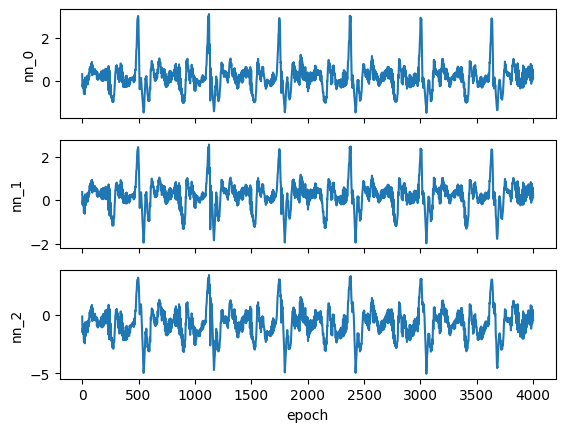

prediction: tensor([[ 0.4485,  0.4800,  0.2965],
        [ 0.2047,  0.2420, -0.2542],
        [-0.0423, -0.0409, -0.7814],
        ...,
        [ 0.3005,  0.2909,  0.4445],
        [ 0.1207,  0.1027,  0.0729],
        [-0.2010, -0.2523, -0.5873]])


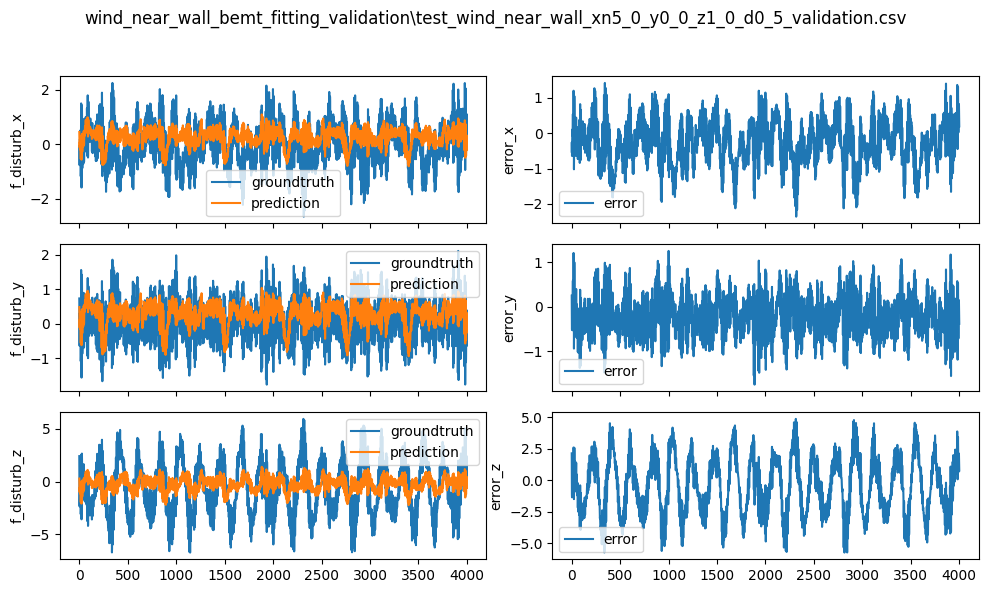

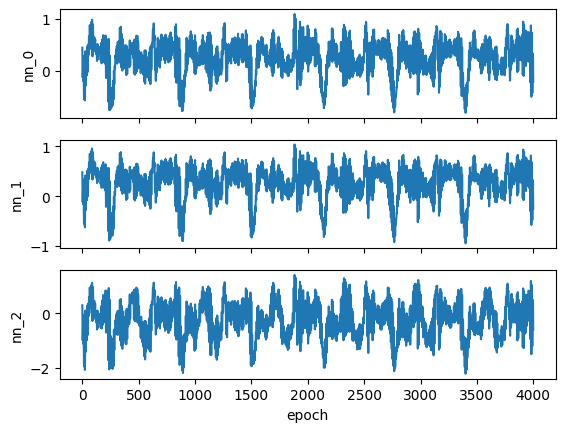

prediction: tensor([[ 0.4051,  0.4469,  0.1541],
        [ 0.1433,  0.1942, -0.4255],
        [-0.0993, -0.0751, -0.9802],
        ...,
        [ 0.0464,  0.0384, -0.1557],
        [-0.1616, -0.1940, -0.5702],
        [-0.4516, -0.4741, -1.2890]])


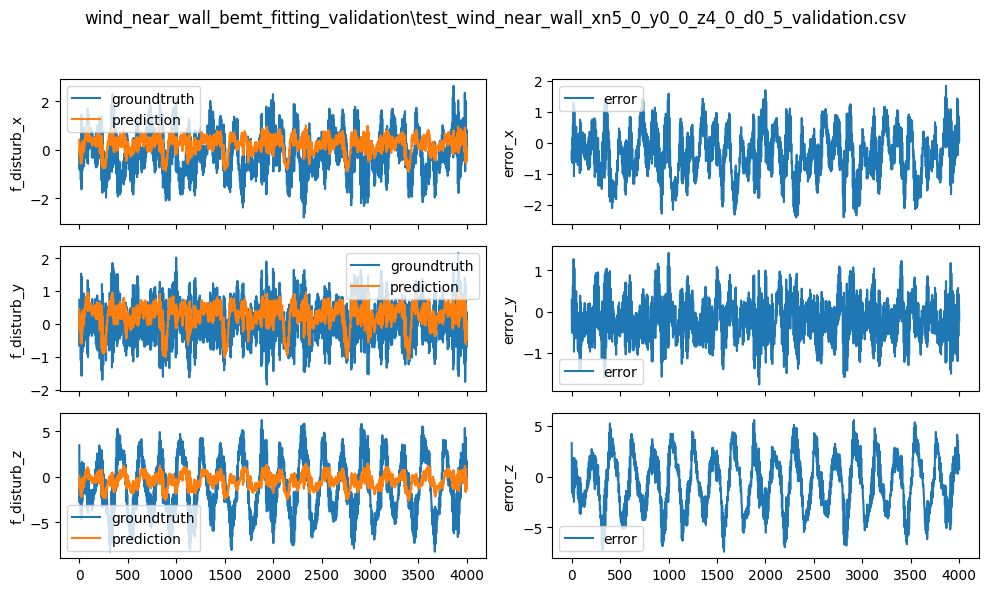

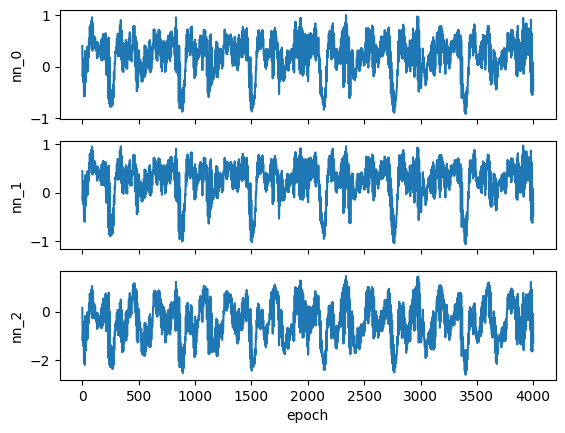

prediction: tensor([[ 0.6483,  0.5890,  0.7034],
        [ 0.3620,  0.3460,  0.2077],
        [ 0.1023,  0.0783, -0.3540],
        ...,
        [ 0.5665,  0.4885,  0.7763],
        [ 0.4079,  0.3462,  0.5426],
        [ 0.1046,  0.0389, -0.0496]])


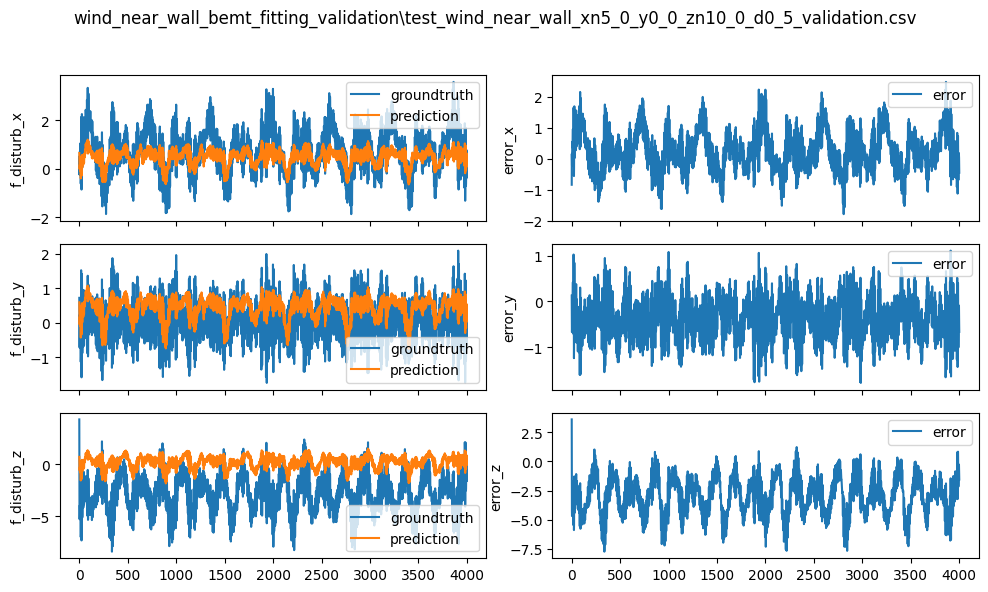

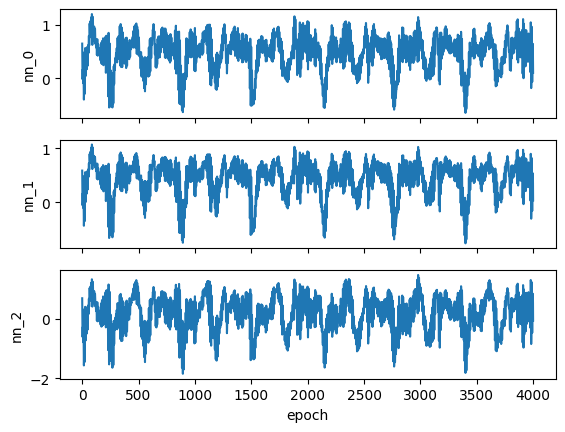

prediction: tensor([[ 0.4787,  0.5000,  0.3717],
        [ 0.2522,  0.2767, -0.1296],
        [-0.0183, -0.0230, -0.6825],
        ...,
        [ 0.3380,  0.3170,  0.5220],
        [ 0.1495,  0.1253,  0.1504],
        [-0.1908, -0.2555, -0.5425]])


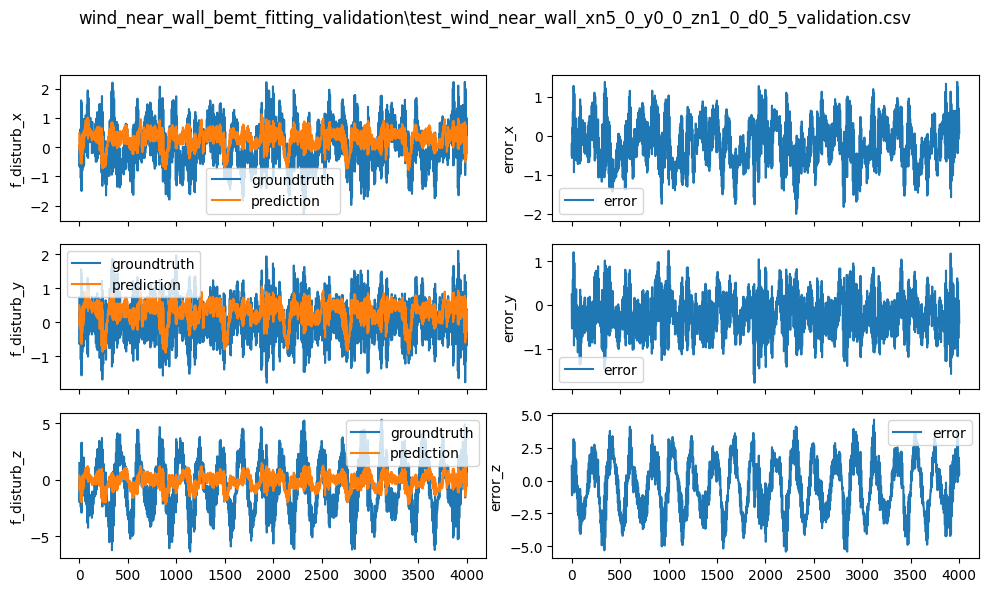

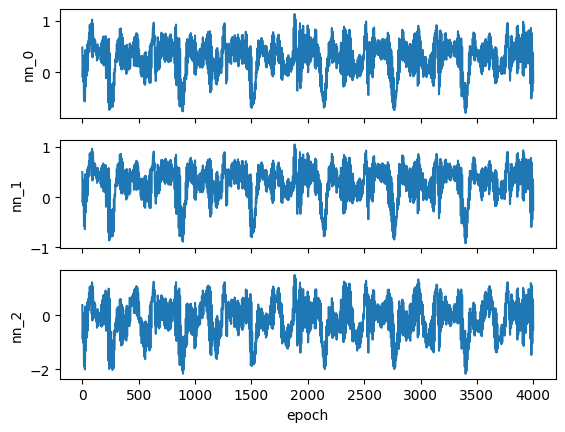

prediction: tensor([[ 0.5291,  0.5321,  0.4812],
        [ 0.2796,  0.2905, -0.0323],
        [-0.0044, -0.0151, -0.6034],
        ...,
        [ 0.4280,  0.3811,  0.6617],
        [ 0.2337,  0.2007,  0.3443],
        [-0.0930, -0.1585, -0.3119]])


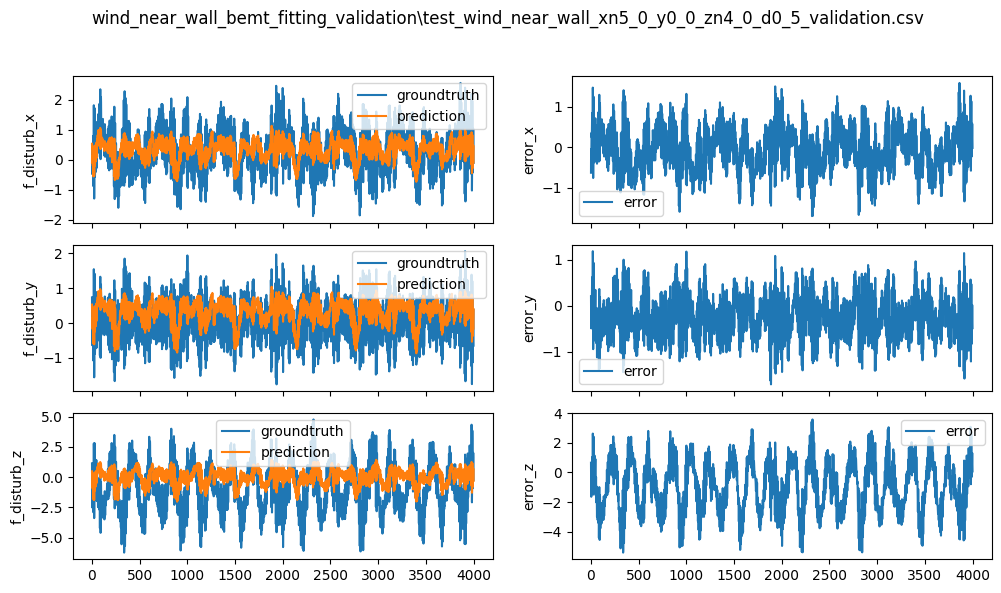

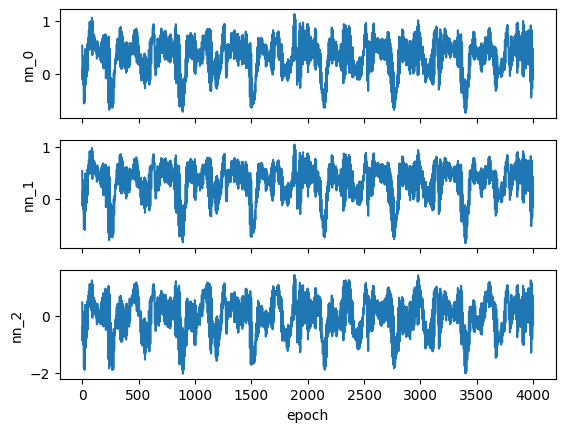

average rms for dim 0: 0.749133342453594
average rms for dim 1: 0.5369307231213778
average rms for dim 2: 2.4484397881316013


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:362: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


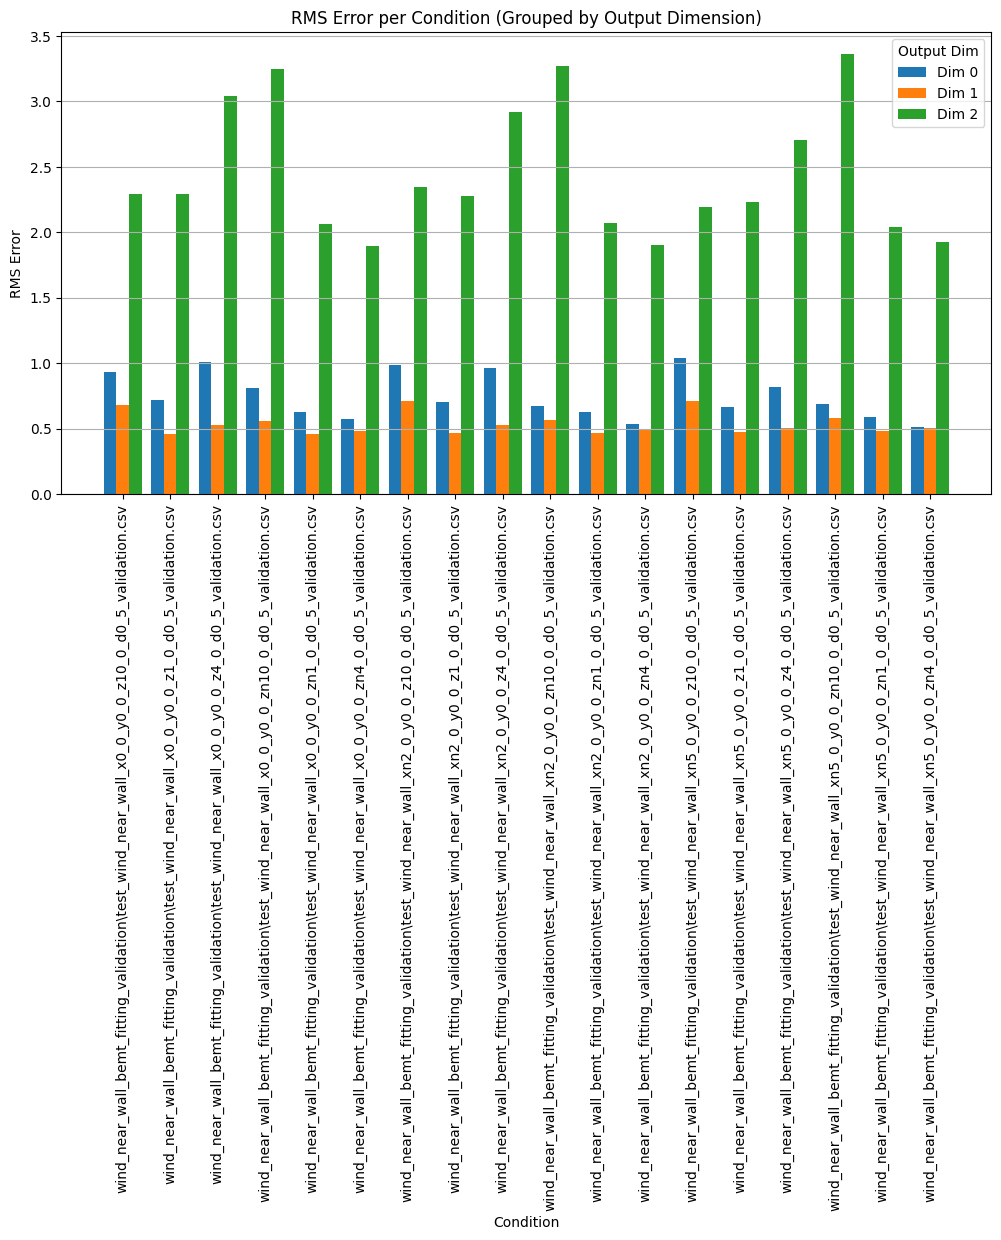

average mse for dim 0: 0.5893272211059188
average mse for dim 1: 0.29498668043892695
average mse for dim 2: 6.234140027518755


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:401: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


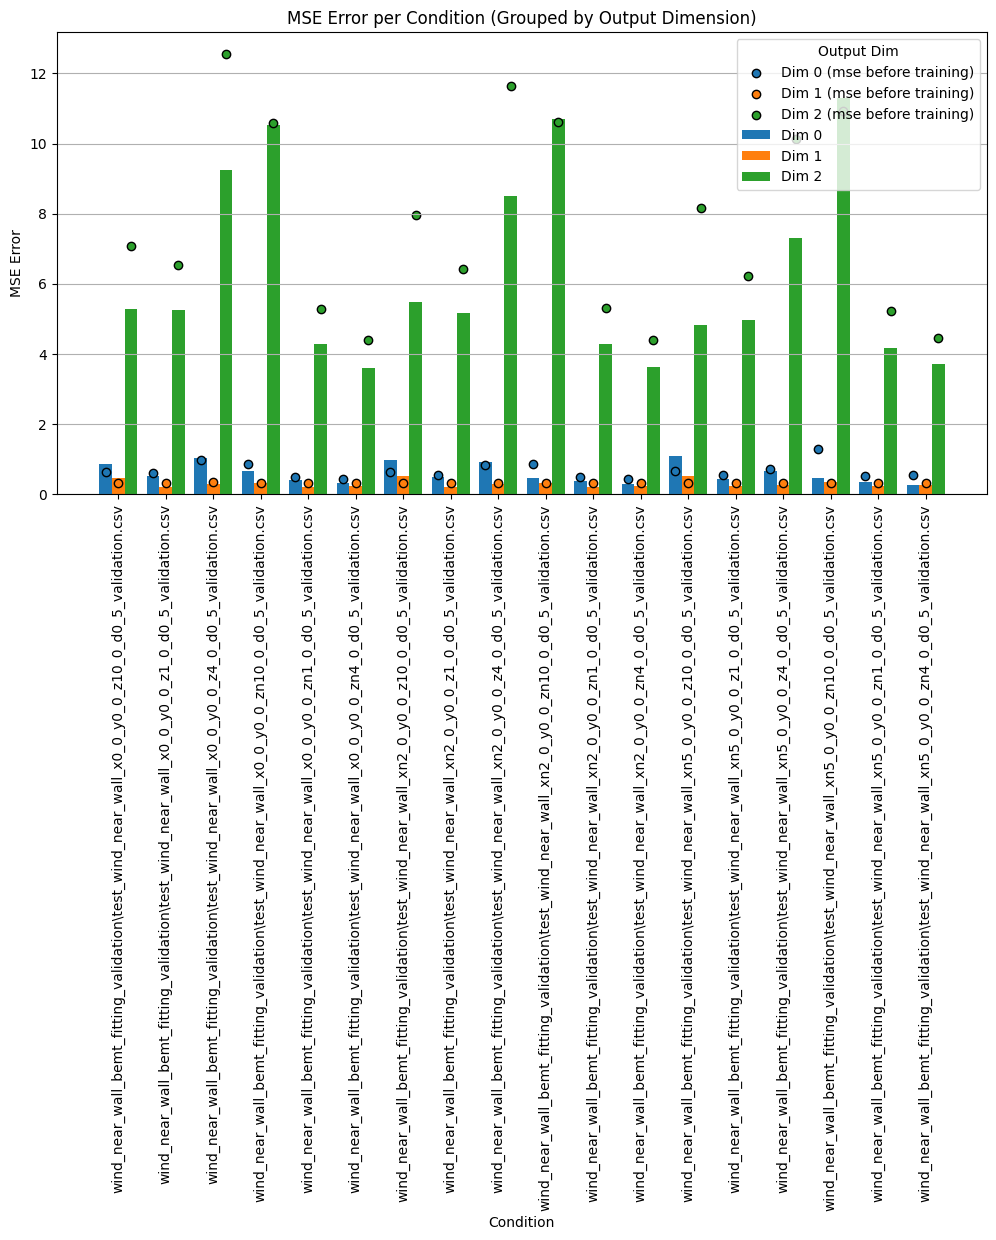

In [5]:
%matplotlib inline
# %matplotlib tk
model_name = training_subfolder

subfolder = validation_subfolder
# subfolder = "wind_near_wall_bemt_fitting_validation"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing
factory = training_manager.PipelineFactory(is_diaml=False)
manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
